In [101]:
import pandas as pd
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [6]:
# path = "/Users/tmullane/Library/CloudStorage/OneDrive-Stanford/Class/Metrics/pset"
file1_path = "src/lalonde_experimental.txt"
data =  pd.DataFrame(np.loadtxt(file1_path))
data.columns = ["treat", "wage"]
data

,treat,wage
0,0.0,0.0000
1,0.0,12.3837
2,0.0,0.0000
3,0.0,10.7401
4,0.0,11.7965
...,...,...
440,1.0,15.9526
441,1.0,36.6469
442,1.0,12.8040
443,1.0,3.7866


1. a. est null hypothesis that there is no effect of the training program on earnings using a t-stat

In [298]:
# H0: Y_i(C) = Y_i(T) for all i
Y_1 = data[data.treat== 1]['wage'].mean()
Y_0 = data[data.treat== 0]['wage'].mean()
N = float(len(data))
M = float(len(data[data.treat == 1]))


In [303]:
diff = (Y_1- Y_0)
diff

np.float64(1.794341237006238)

In [305]:
s_0_sq =(1/(N-M-1)) * sum((data[data.treat == 0].wage - Y_0)**2)
s_1_sq = 1/(M - 1) * sum((data[data.treat == 1].wage - Y_1)**2)

print(s_0_sq, s_1_sq)

30.072442829845404 61.895995980595195


In [306]:
s_diff_sq = s_0_sq/(N-M) + s_1_sq/M

In [307]:
ttest = float(diff/(math.sqrt(s_diff_sq)))
print("t-test = " ,ttest)

t-test =  2.6741442860339806


In [308]:
p = 2 * (1-norm.cdf(abs(ttest)))
print("p-value = " ,float(p))

p-value =  0.007492020981215264


1.b.

In [247]:
# randomly assign binary treatment to each individual and calculate the average treatment effect 100 times
# 1. Generate random treatment assignment
np.random.seed(123)
random_treat = np.random.choice([0, 1], size=(1000000,int(N)), p=[1-M/N, M/N])
len(random_treat)

1000000

In [276]:
base = np.array([1]*int(M) + [0]*int((N - M)))
random_treat = np.tile(base, (1000000, 1))

# Shuffle each row independently
for row in random_treat:
    np.random.shuffle(row)

# Y_1 = data[data.treat == 1].wage.to_numpy()
# Y_0 = data[data.treat == 0].wage.to_numpy()

# observed = (random_treat * Y_1) + ((1 - random_treat) * Y_0)

# # wages = data["wage"].to_numpy()
# # wages_expand = wages[None, :]
# treated = random_treat == 1
# control = random_treat == 0

# treated_means = np.sum(treated * observed, axis=1) / np.sum(treated, axis=1)
# control_means = np.sum(control * observed, axis=1) / np.sum(control, axis=1)

# ates = treated_means - control_means

In [277]:
np.sum(random_treat[0] == 1)

np.int64(185)

In [278]:
wages = data["wage"].to_numpy()
wages_expand = wages[None, :]
treated = random_treat == 1
control = random_treat == 0

treated_means = np.sum(treated * wages_expand, axis=1) / np.sum(treated, axis=1)
control_means = np.sum(control * wages_expand, axis=1) / np.sum(control, axis=1)

ates = treated_means - control_means

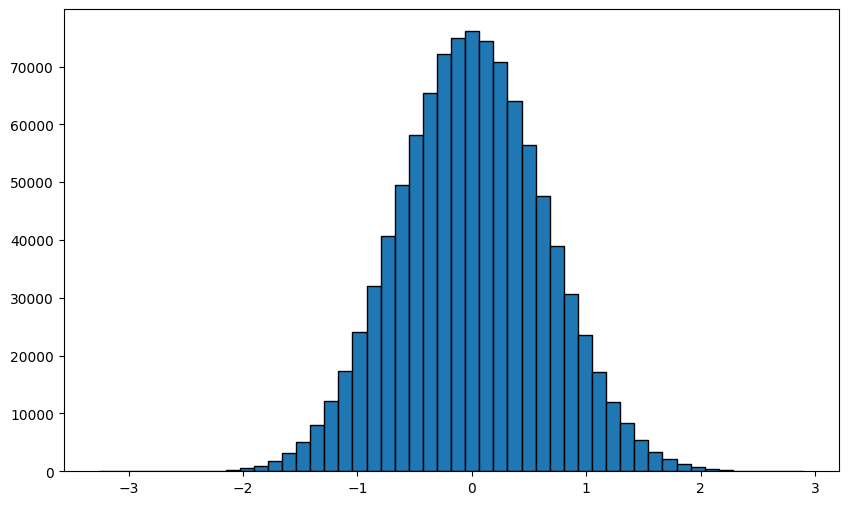

In [279]:
plt.figure(figsize=(10, 6))
plt.hist(ates, bins=50, edgecolor='black')
plt.show()

In [280]:
print("p-value = ", np.sum(ates[abs(ates) > diff])/1000000)

p-value =  0.001273974969615385


c.

In [171]:
data["rank"] = data["wage"].rank()

In [282]:
data["R"]  = data['wage'].apply(lambda y: (data['wage'] < y).sum() + 0.5 * (1 + (data['wage'] == y).sum()) - (N + 1)/2)

In [289]:
y_w1 = data[data.treat == 1].aggregate({"rank": "sum", "treat": "count"})
y_w0 = data[data.treat == 0].aggregate({"rank": "sum", "treat": "count"})
diff_r = (y_w1["rank"]/y_w1["treat"] - y_w0["rank"]/y_w0["treat"])
diff_r

np.float64(31.015852390852388)

In [172]:
rank = data["rank"].to_numpy()
rank_expand = rank[None, :]

In [283]:
treated_means_rank = np.sum(treated * rank_expand, axis=1) / np.sum(treated, axis=1)
control_means_rank = np.sum(control * rank_expand, axis=1) / np.sum(control, axis=1)

ates_rank = treated_means_rank - control_means_rank

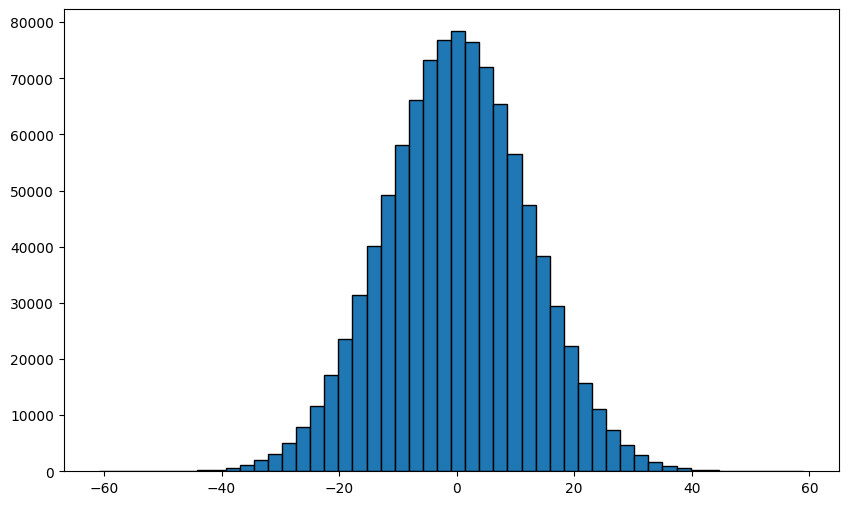

In [284]:
plt.figure(figsize=(10, 6))
plt.hist(ates_rank, bins=50, edgecolor='black')
plt.show()

In [290]:
# count what the rate of ates are less than T_obs
print("p-value = ", np.sum(ates_rank[abs(ates_rank) < diff_r])/1000000)

p-value =  0.02349617115384616


1.d.

In [177]:
np.sum(data.wage[data.treat==1])/M - np.sum(data.wage[data.treat==0])/(N-M)

np.float64(1.794341237006238)

In [293]:
s_2c = (1/(N-M-1))*np.sum((data.wage[data.treat==0]-np.mean(data.wage[data.treat==0]))**2)
s_2t = (1/(M-1))*np.sum((data.wage[data.treat==1]-np.mean(data.wage[data.treat==1]))**2)

In [294]:
var_hat = s_2t/M - s_2c/(N-M)
var_hat

np.float64(0.21890970959320882)

In [296]:
treat_effect = Y_1 - Y_0

In [297]:
# 95% confidence intervals
ci_lower = treat_effect - 1.96 * np.sqrt(s_diff_sq)
ci_upper = treat_effect + 1.96 * np.sqrt(s_diff_sq)
print(ci_lower, ci_upper)

0.47918825782718666 3.109494216185289


In [197]:
mean_1 = np.mean(data.wage[data.treat==1])
mean_0 = np.mean(data.wage[data.treat==0])

def error_term(row):
    if row['treat'] == 1:
        return row.wage - mean_1
    else:
        return row.wage - mean_0

# apply the error term function to each row of the data
data['error'] = data.apply(error_term, axis=1)

The homoskedastic varriance estimate is larger than the Neyman variance estimator.

In [207]:
mean_treat = np.mean(data.treat)
var_homo = np.sum((data.error)**2/N)/np.sum((data.treat-mean_treat)**2)
var_homo

np.float64(0.3987032422735858)

In [309]:
# 95% confidence intervals
ci_lower_homo = treat_effect - 1.96 * np.sqrt(var_homo)
ci_upper_homo = treat_effect + 1.96 * np.sqrt(var_homo)
print(ci_lower, ci_upper)

0.47918825782718666 3.109494216185289


2.

In [217]:
sig = 0.05
std_dev = 6.63
effect = 1.79
power = 0.8

In [226]:
norm.ppf(1-0.8)

np.float64(-0.8416212335729143)

In [227]:
n = (((norm.ppf(1-sig/2) + abs(norm.ppf(1-0.8)))*std_dev)/effect)**2
n

np.float64(107.67841877432336)

b.

In [228]:
effect = 0.11
std_dev = 0.46

In [229]:
n = (((norm.ppf(1-sig/2) + abs(norm.ppf(1-0.8)))*std_dev)/effect)**2
n

np.float64(137.258095189113)

The difference in sample size is related to ____